In [111]:
#load all necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.cm as cm
import seaborn as sns
%matplotlib inline

from IPython.display import display

import warnings
warnings.filterwarnings("ignore")

In [112]:
data = pd.read_csv('Data/bids.csv')
data.drop(['ip', 'url'], axis = 1, inplace = True)
data.head()

,bid_id,bidder_id,auction,merchandise,device,time,country
0,0,8dac2b259fd1c6d1120e519fb1ac14fbqvax8,ewmzr,jewelry,phone0,9759243157894736,us
1,1,668d393e858e8126275433046bbd35c6tywop,aeqok,furniture,phone1,9759243157894736,in
2,2,aa5f360084278b35d746fa6af3a7a1a5ra3xe,wa00e,home goods,phone2,9759243157894736,py
3,3,3939ac3ef7d472a59a9c5f893dd3e39fh9ofi,jefix,jewelry,phone4,9759243157894736,in
4,4,8393c48eaf4b8fa96886edc7cf27b372dsibi,jefix,jewelry,phone5,9759243157894736,in


In [113]:
bidder_train = pd.read_csv('Data/train.csv')
bidder_train.drop(['payment_account', 'address'], axis=1, inplace = True)
bidder_train.head()

,bidder_id,outcome
0,91a3c57b13234af24875c56fb7e2b2f4rb56a,0.0
1,624f258b49e77713fc34034560f93fb3hu3jo,0.0
2,1c5f4fc669099bfbfac515cd26997bd12ruaj,0.0
3,4bee9aba2abda51bf43d639013d6efe12iycd,0.0
4,4ab12bc61c82ddd9c2d65e60555808acqgos1,0.0


In [114]:
bidder_test = pd.read_csv('Data/test.csv')
bidder_test.drop(['payment_account', 'address'], axis=1, inplace = True)
bidder_test.head()

,bidder_id
0,49bb5a3c944b8fc337981cc7a9ccae41u31d7
1,a921612b85a1494456e74c09393ccb65ylp4y
2,6b601e72a4d264dab9ace9d7b229b47479v6i
3,eaf0ed0afc9689779417274b4791726cn5udi
4,cdecd8d02ed8c6037e38042c7745f688mx5sf


In [115]:
#Feature: Number of auctions
df = data[['bidder_id', 'auction', 'merchandise']].groupby(['bidder_id', 'auction']).count()
#min, max, mean
min_num_bids = df.merchandise.min(level=0)
max_num_bids = df.merchandise.max(level=0)
avg_num_bids = df.merchandise.mean(level=0)
std_num_bids = df.merchandise.std(level=0).fillna(0)

In [116]:
#Feature: Speed of making bids
start_time = data[['bidder_id','time','auction']].groupby(['bidder_id','auction']).time.min()
end_time = data[['bidder_id', 'time', 'auction']].groupby(['bidder_id','auction']).time.max()
time_interval = pd.DataFrame((end_time - start_time)*10e-10).rename(columns={0: 'time'})
#nbids = num_bids.reset_index().sort('bidder_id').bid_id
time = time_interval.reset_index().time
nbids = data[['bidder_id', 'bid_id', 'auction']].groupby(['bidder_id', 'auction']).bid_id.count()
nbids = nbids.reset_index().rename(columns={0:'num_bids'})
nbids_s = nbids.bid_id
nbids['speed'] = (nbids_s/time)
nbids.replace(np.inf, 0, inplace = True)

In [117]:
min_speed = nbids.groupby('bidder_id').speed.min()
max_speed = nbids.groupby('bidder_id').speed.max()
avg_speed = nbids.groupby('bidder_id').speed.mean()
std_speed = nbids.groupby('bidder_id').speed.std().fillna(0)

In [118]:
#Feature: Countries
#data[['country', 'device']] = data[['country', 'device']].astype('category').apply(lambda x:x.cat.codes)
countries_auc = data[['bidder_id', 'country', 'auction']].groupby(['bidder_id', 'auction']).country.count()

In [119]:
min_num_cou = countries_auc.min(level=0)
max_num_cou = countries_auc.max(level=0)
mean_num_cou = countries_auc.mean(level=0)
std_num_cou = countries_auc.std(level=0).fillna(0)

In [120]:
#Feature: device
devices_auc = data[['bidder_id', 'device', 'auction']].groupby(['bidder_id', 'auction']).device.count()

In [121]:
min_dev = devices_auc.min(level=0)
max_dev = devices_auc.max(level=0)
mean_dev = devices_auc.mean(level=0)
std_dev = devices_auc.std(level=0).fillna(0)

In [122]:
d = {'min_num_bids':min_num_bids, 'max_num_bids': max_num_bids, 'avg_num_bids':avg_num_bids,
     'min_speed':min_speed, 'max_speed':max_speed, 'avg_speed':avg_speed,
     'min_num_cou':min_num_cou, 'max_num_cou':max_num_cou, 'avg_num_cou': mean_num_cou,
     'min_dev':min_dev, 'max_dev':max_dev, 'avg_dev': mean_dev}
     #'std_num_bids': std_num_bids, 'std_num_cou':std_num_cou, 'std_speed':std_speed, 'std_dev':std_dev}

In [123]:
features = pd.DataFrame(d).reset_index()

In [124]:
merged_train = pd.merge(bidder_train, features, left_on='bidder_id', right_on='bidder_id')

In [125]:
ddd = data[['bidder_id', 'merchandise','bid_id']].groupby(['bidder_id', 'merchandise']).count()
ddd = ddd.reset_index('merchandise')
ddd.drop('bid_id', axis = 1, inplace = True)
dddd = pd.merge(merged_train, ddd, left_on='bidder_id', right_index = True, how = 'left')
dddd.merchandise = dddd.merchandise.astype('category')
dddd.merchandise = dddd[['merchandise']].apply(lambda x:x.cat.codes)

In [126]:
cccc = data[['country', 'bidder_id']].groupby('bidder_id')['country'].nunique()
cccc = cccc.reset_index()
ccccc = pd.merge(dddd, cccc, left_on = 'bidder_id', right_on = 'bidder_id', how='left')

In [127]:
devices = data[['device', 'bidder_id']].groupby('bidder_id')['device'].nunique()
devices = devices.reset_index()
abcde = pd.merge(ccccc, devices, left_on='bidder_id', right_on='bidder_id', how='left')

In [128]:
labels = abcde['outcome']
train_data = abcde.drop('outcome', axis=1)

In [129]:
train = train_data.set_index('bidder_id')

In [130]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train, labels, test_size = 0.2)

### check proportion of robot bidders for both train data and test data:

In [21]:
y_train.sum()/len(y_train)

0.05100755667506297

In [22]:
y_test.sum()/len(y_test)

0.055415617128463476

In [131]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
rfc.score(X_test, y_test)

0.94458438287153657

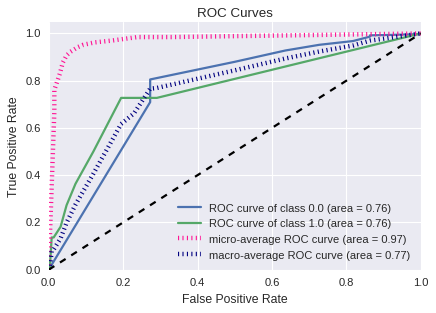

In [30]:
from scikitplot.plotters import plot_roc_curve
_ = plot_roc_curve(y_test, rfc.predict_proba(X_test))

In [74]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
#knn.fit(X_train, y_train)
#knn.score(X_test, y_test)

In [191]:
parameters = {'n_neighbors' :  range(1, 15)}
clf_knn = GridSearchCV(knn, parameters, cv = 5)
clf_knn.fit(X_train, y_train)
clf_knn.score(X_test, y_test)

0.94710327455919396

In [197]:
clf_knn.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=9, p=2,
           weights='uniform')

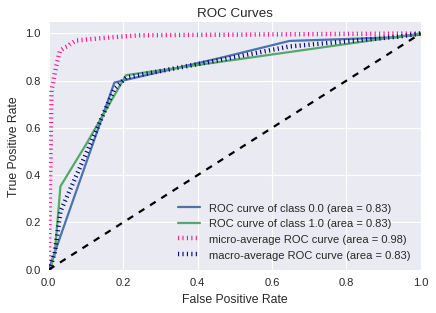

In [192]:
_ = plot_roc_curve(y_test, clf_knn.predict_proba(X_test))

In [107]:
from sklearn.linear_model import LogisticRegression
lgr = LogisticRegression()
#lgr.fit(X_train, y_train)
#lgr.score(X_test, y_test)

In [108]:
from sklearn.model_selection import GridSearchCV
parameters = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
clf = GridSearchCV(lgr, parameters, cv = 5)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.93702770780856426

In [109]:
clf.best_estimator_

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

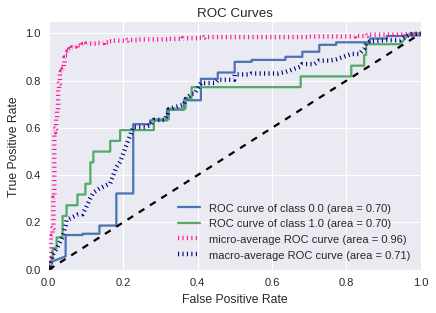

In [106]:
_ = plot_roc_curve(y_test,clf.predict_proba(X_test))

In [92]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier()
ada.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

In [93]:
ada.score(X_test, y_test)

0.93198992443324935

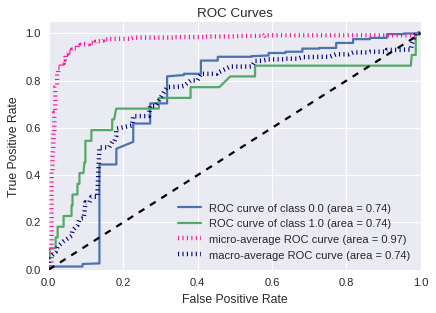

In [94]:
plot_roc_curve(y_test, ada.predict_proba(X_test))

## Over-sampliong

In [135]:
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.pipeline import make_pipeline

adasyn = ADASYN()
smote = SMOTE()
rdos = RandomOverSampler()

pipeline_a = make_pipeline(adasyn, rfc)
pipeline_a.fit(X_train, y_train)

Pipeline(steps=[('adasyn', ADASYN(k=None, n_jobs=1, n_neighbors=5, random_state=None, ratio='auto')), ('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-...imators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))])

In [136]:
pipeline_a.score(X_test, y_test)

0.93702770780856426

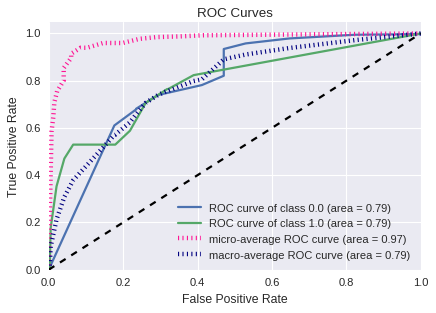

In [137]:
plot_roc_curve(y_test, pipeline_a.predict_proba(X_test))

In [193]:
pipeline_s = make_pipeline(smote, rfc)
pipeline_s.fit(X_train, y_train)
pipeline_s.score(X_test, y_test)

0.92947103274559195

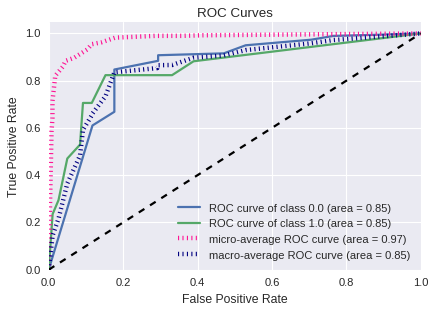

In [194]:
plot_roc_curve(y_test, pipeline_s.predict_proba(X_test))

In [140]:
pipeline_r = make_pipeline(rdos, rfc)
pipeline_r.fit(X_train, y_train)
pipeline_r.score(X_test, y_test)

0.94710327455919396

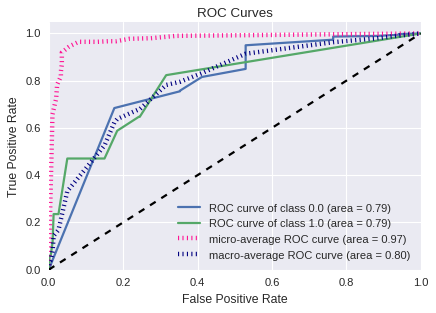

In [141]:
plot_roc_curve(y_test, pipeline_r.predict_proba(X_test))

In [157]:
from imblearn.under_sampling import TomekLinks

pipeline_us = make_pipeline(TomekLinks(), rfc)
pipeline_us.fit(X_train, y_train)
pipeline_us.score(X_test, y_test)

0.94962216624685136

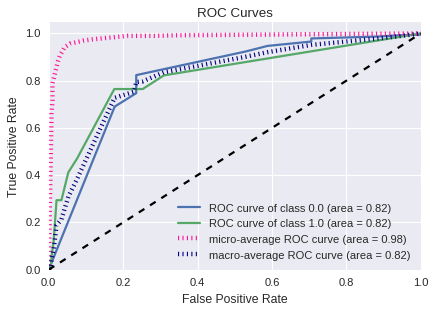

In [158]:
plot_roc_curve(y_test, pipeline_us.predict_proba(X_test))

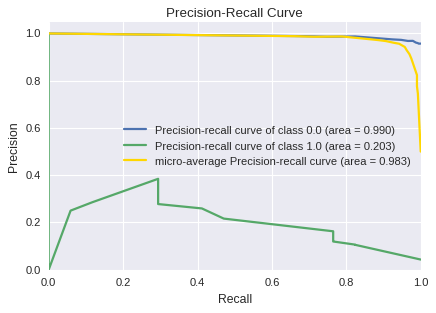

In [159]:
from scikitplot.plotters import plot_precision_recall_curve
plot_precision_recall_curve(y_test, pipeline_s.predict_proba(X_test))

In [171]:
from sklearn.metrics import f1_score

f1_score(y_test, pipeline_s.predict(X_test))

0.16666666666666666

In [175]:
merged_test = pd.merge(bidder_test, features, left_on = 'bidder_id', right_on = 'bidder_id', how = 'left').fillna(0)

In [178]:
ddd = data[['bidder_id', 'merchandise','bid_id']].groupby(['bidder_id', 'merchandise']).count()
ddd = ddd.reset_index('merchandise')
ddd.drop('bid_id', axis = 1, inplace = True)
dddd = pd.merge(merged_test, ddd, left_on='bidder_id', right_index = True, how = 'left')
dddd.merchandise = dddd.merchandise.astype('category')
dddd.merchandise = dddd[['merchandise']].apply(lambda x:x.cat.codes)
cccc = data[['country', 'bidder_id']].groupby('bidder_id')['country'].nunique()
cccc = cccc.reset_index()
ccccc = pd.merge(dddd, cccc, left_on = 'bidder_id', right_on = 'bidder_id', how='left')
devices = data[['device', 'bidder_id']].groupby('bidder_id')['device'].nunique()
devices = devices.reset_index()
abcde = pd.merge(ccccc, devices, left_on='bidder_id', right_on='bidder_id', how='left')

In [179]:
test_data = abcde.set_index('bidder_id')

In [196]:
pred = clf_knn.predict_proba(test_data.fillna(0))
pred_df = pd.DataFrame(pred)
results = pd.merge(bidder_test, pred_df, left_index = True, right_index = True).rename(columns={1:'prediction'})
results.drop(0, axis = 1, inplace=True)
results.to_csv('submission.csv',index=False)

Black box scores (evaluated by Area Under ROC):

Logistic Regression with regularization (C=10): 0.69

knn with fine-tuning (n_neighbors=9): 0.83

Random Forest with over-sampling SMOTE (without fine-tuning): 0.83